# Coherence Analyses

Testing out ideas about the relation of singular value decay to decay of eigenvalues of coherence matrix.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

In [35]:
import scipy.signal as ss
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import ifft

In [36]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = loadBradyHShdf5(file,normalize='no')
samples_per_sec=1000

Function for low rank approximation with randomized SVD

In [37]:
def randomized_SVD_comp_decomp(data, compression_factor):
    """
    Compress data with randomized SVD by compression factor and return
    reconstructed data.

    Parameters
    ----------
    data : 2-dimensional numpy array
        Data to be compressed.
    compression_factor : int/float
        Compression factor.

    Returns
    -------
    recon : 2-dimensional numpy array
        Reconstructed data after compression.
    compression_factor : float/int
        Same as input compression_factor

    """
    from sklearn.utils.extmath import randomized_svd

    rows, columns = data.shape
    approxRank = int((rows * columns) / (compression_factor * (rows + columns)))
    # calculate randomized SVD and reconstruct
    U, S, Vt = randomized_svd(data, n_components=approxRank)
    
    plt.plot(S)
    recon = U @ np.diag(S) @ Vt

    return recon, compression_factor

Plot data

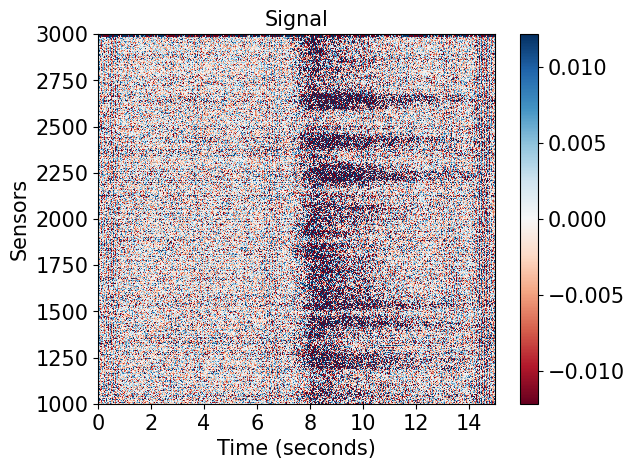

In [38]:
fsize=15
pdata=data[:,10000:25000] # signalToUse[1900:3900]
start_ch = 1000
nchannels = 2000
pdata = pdata[start_ch:nchannels+start_ch]
fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Select parts of data, do a randomized SVD and plot singular values

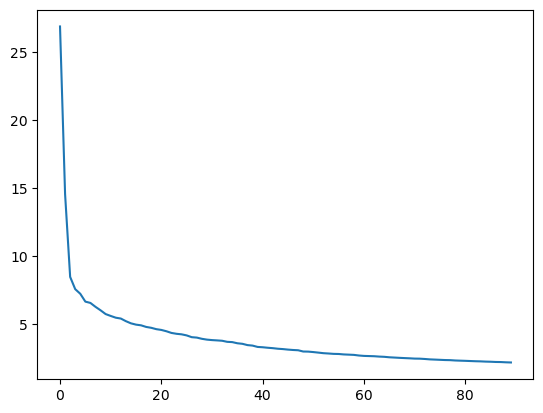

In [5]:
pdata=data[:,5000:25000] 
pdata = pdata[start_ch:nchannels+start_ch]
pdata, _ = randomized_SVD_comp_decomp(pdata, 20)

Plot coherence between 2 signals

Text(0, 0.5, 'Coherence')

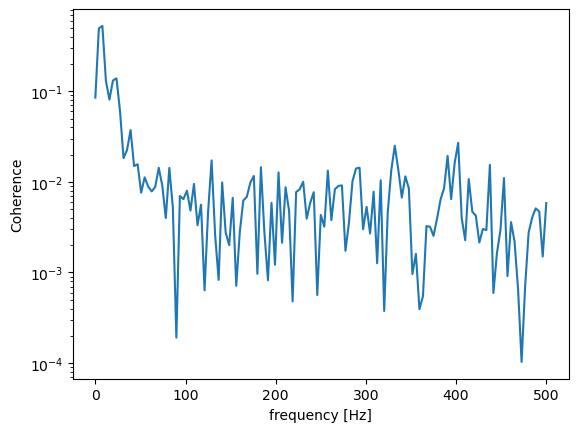

In [39]:
f, Cxy = ss.coherence(pdata[1000], pdata[1500], fs=1000) #, nperseg=1024)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')

plot ifft of previously computed coherence between signals

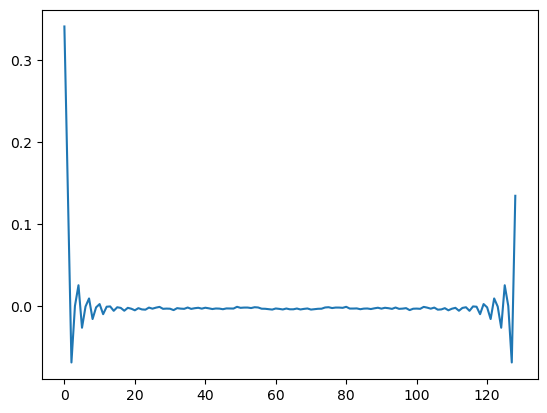

In [9]:
rt = ifft(Cxy)
plt.plot(rt)

In [8]:
nsensors = 200
i = 0
j = 0
cube = np.empty([nsensors, nsensors, len(Cxy)])
for a in np.linspace(0,len(pdata)-1,nsensors):
    for b in np.linspace(0,len(pdata)-1,nsensors):
        a=int(a)
        b=int(b)
        f, C = ss.coherence(pdata[a], pdata[int(b)], fs=1000)
        cube[i,j,:] = C
        j+=1
    i+=1
    j=0

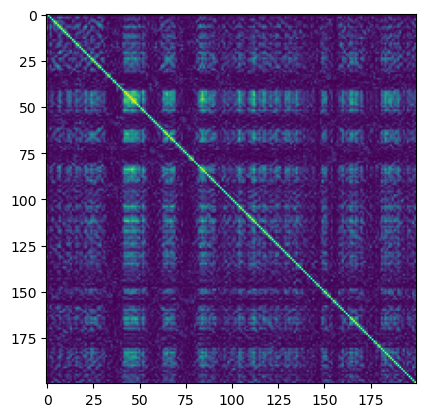

In [23]:
plt.imshow(cube[:,:,3])

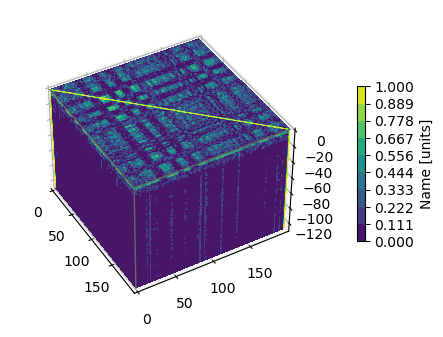

In [10]:
Nx, Ny, Nz = np.shape(cube)
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

kw = {
    'vmin': cube.min(),
    'vmax': cube.max(),
    'levels': np.linspace(cube.min(), cube.max(), 10),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], cube[:, :, 0],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], cube[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    cube[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
# ax.set(
#     xlabel='X [km]',
#     ylabel='Y [km]',
#     zlabel='Z [m]',
#     zticks=[0, -150, -300, -450],
# )

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.9)

# Colorbar
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

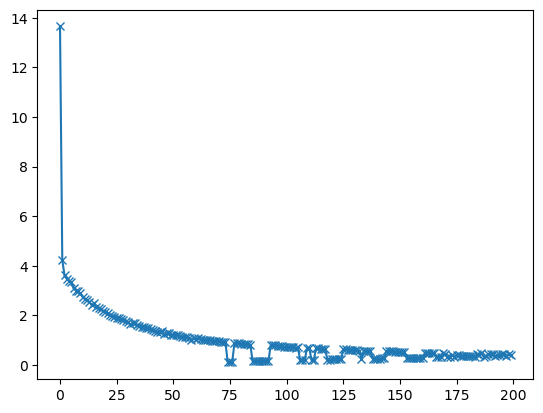

In [20]:
eigenvals, eigenvecs = np.linalg.eig(cube[:,:,10])
plt.plot(eigenvals, "-x")
# eigenvals[0]

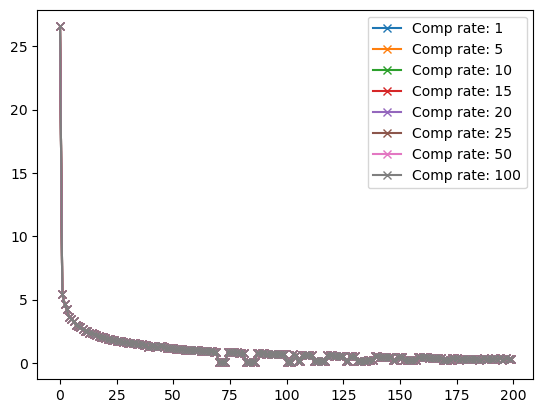

In [41]:
from sklearn.utils.extmath import randomized_svd

compression_factors = [1,5,10,15,20,25,50,100]
pdata=data[:,5000:25000] 
pdata = pdata[start_ch:nchannels+start_ch]
rows, columns = pdata.shape
nsensors = 200
evs = np.array([range(nsensors)])


approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
# calculate randomized SVD and reconstruct
U, S, Vt = randomized_svd(pdata, n_components=approxRank)

for compression_factor in compression_factors:
    approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
    recon = U[:,:approxRank] @ np.diag(S[:approxRank]) @ Vt[:approxRank,:]

    i = 0
    j = 0
    cube = np.empty([nsensors, nsensors, len(Cxy)])
    for a in np.linspace(0,len(recon)-1,nsensors):
        for b in np.linspace(0,len(recon)-1,nsensors):
            a=int(a)
            b=int(b)
            f, C = ss.coherence(recon[a], recon[int(b)], fs=1000)
            cube[i,j,:] = C
            j+=1
        i+=1
        j=0
    eigenvals, eigenvecs = np.linalg.eig(cube[:,:,3])
    plt.plot(eigenvals, '-x', label="Comp rate: "+ str(compression_factor))
    evs = np.append(evs, eigenvals[np.newaxis,:], axis=0)
plt.legend()
    

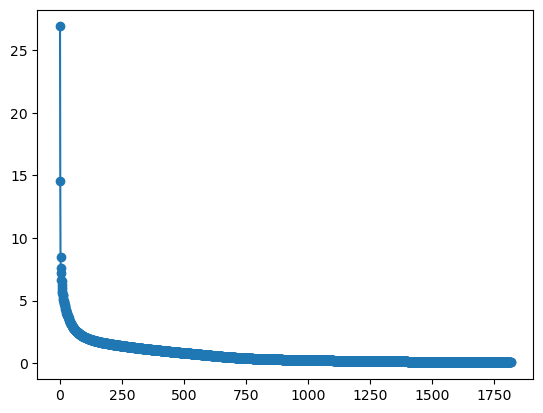

In [42]:
# np.append(eigenvals[np.newaxis,:], eigenvals[np.newaxis,:], axis=0).shape
# evs = np.array([range(200)])
# evs
approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
# calculate randomized SVD and reconstruct
# U, S, Vt = randomized_svd(data, n_components=approxRank)
plt.plot(S, "-o")
# plt.plot(S*S[0], "-s")

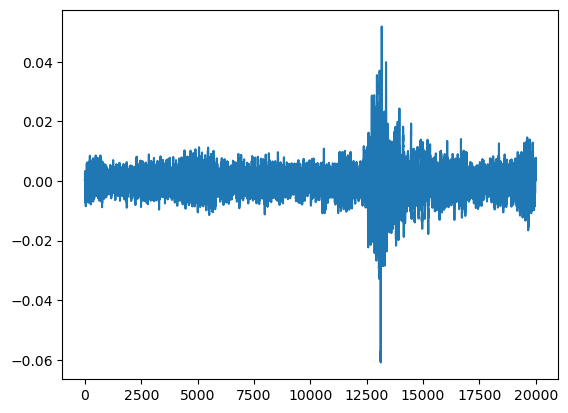

In [27]:
plt.plot(pdata[50])

129


c:\Users\issah\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


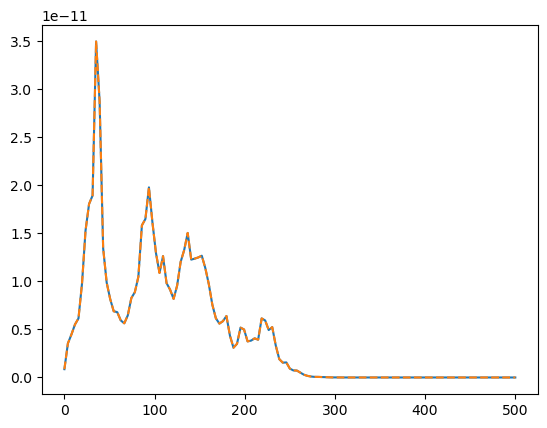

In [36]:
# plt.plot(pdata[1])
# plt.plot(ss.welch(pdata[50]))
f, Pxy = ss.welch(pdata[50], fs=1000)
plt.plot(f, Pxy)
f, Pxx = ss.csd(pdata[50], pdata[50], fs=1000)
plt.plot(f, Pxx, '--')
print(len(f))

In [ ]:
def PSDMatrix():
    n_channels = len(signal)
    n_samples = len(signal[1])
    samples_per_sec = 1000
    n_frequencies = 129
    window_length = 5000
    Pxy = np.empty([n_samples, n_samples, n_frequencies])
    for a in range(n_channels):
        for b in range(n_channels):
            Pxy[a,b,:] = ss.csd(pdata[50], pdata[50], fs=1000, nperseg=window_length)
    return Pxy

file_count = 0
for a in files:
    signal = load(a)
    if file_count == 0:
        Pxy = PSDMatrix()
    else:
        Pxy += PSDMatrix()



In [40]:
print(pdata[1])
a = pdata[1]
a += pdata[1]
print(a)

[ 7.8033794e-05  3.8920969e-04  2.7194523e-04 ... -3.0161276e-05
  5.7325527e-05 -1.6018793e-04]
[ 1.56067588e-04  7.78419373e-04  5.43890463e-04 ... -6.03225526e-05
  1.14651055e-04 -3.20375868e-04]
